В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [45]:
import pandas as pd
import numpy as np
%reload_ext autoreload
%autoreload 2
import sys
import os
modules_path = os.path.abspath("modules")
if modules_path not in sys.path:
    sys.path.append(modules_path)
from process_bank_churn import process_data


clients_df = pd.read_csv('csv/train.csv')

data = process_data(clients_df, True)

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [46]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(data['X_train'], data['train_targets'])

KNeighborsClassifier()

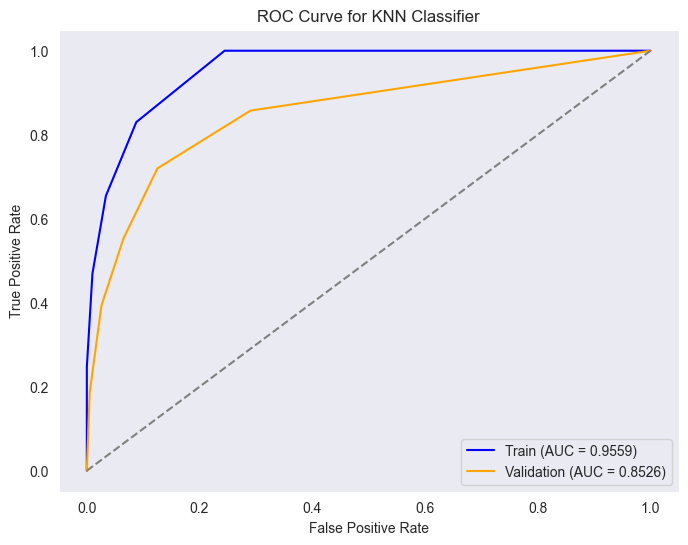

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

def plot_roc_curve(data, knn ):
    y_train_probs = knn.predict_proba(data['X_train'])[:, 1]
    y_val_probs = knn.predict_proba(data['X_val'])[:, 1]

    fpr_train, tpr_train, _ = roc_curve(data['train_targets'], y_train_probs)
    auc_train = auc(fpr_train, tpr_train)

    fpr_val, tpr_val, _ = roc_curve(data['val_targets'], y_val_probs)
    auc_val = auc(fpr_val, tpr_val)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc_train:.4f})', color='blue')
    plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {auc_val:.4f})', color='orange')

    # Plot diagonal reference line (random model)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

    # Labels and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for KNN Classifier')
    plt.legend(loc='lower right')
    plt.grid()

    # Show plot
    plt.show()

plot_roc_curve(data, knn)

As we can see, Train AUC is 0.9559, which is quite good score. But Validation AUC is 0.8526 which is almost 0.10 smaller than on train dataset. These numbers say that the model is slightly overfitted right now and it does not generalize perfectly. But, overall, the model is quite good.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'n_neighbors': 9} 0.8671666666666666


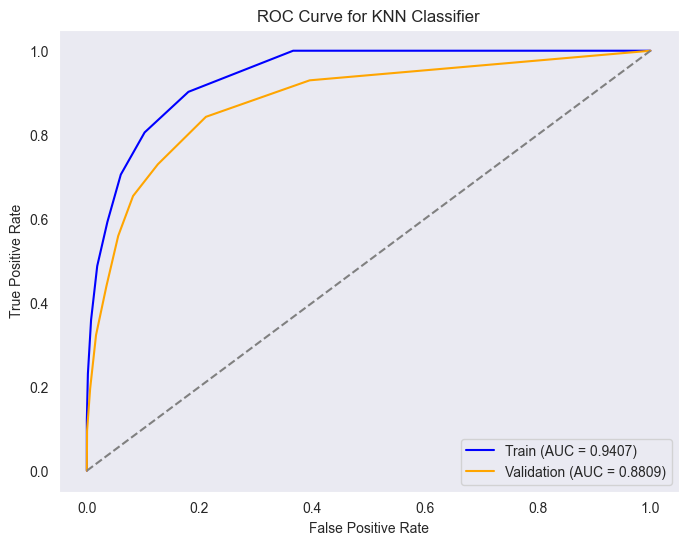

In [48]:
from sklearn.model_selection import GridSearchCV

params_knn = {'n_neighbors': np.arange(1, 25)}
knn_gs = GridSearchCV(knn, params_knn, n_jobs=-1, cv=5, verbose=1)
knn_gs.fit(data['X_train'], data['train_targets'])

knn_best = knn_gs.best_estimator_
print(knn_gs.best_params_, knn_gs.best_score_)

plot_roc_curve(data, knn_best)

Here we can see that model had become slightly better, but it is still overfitted a little bit. It is still not as good as decision tre from previous home assignment.

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Training time: 0.49 seconds
{'max_depth': 5, 'max_leaf_nodes': 10} 0.9013929183420709


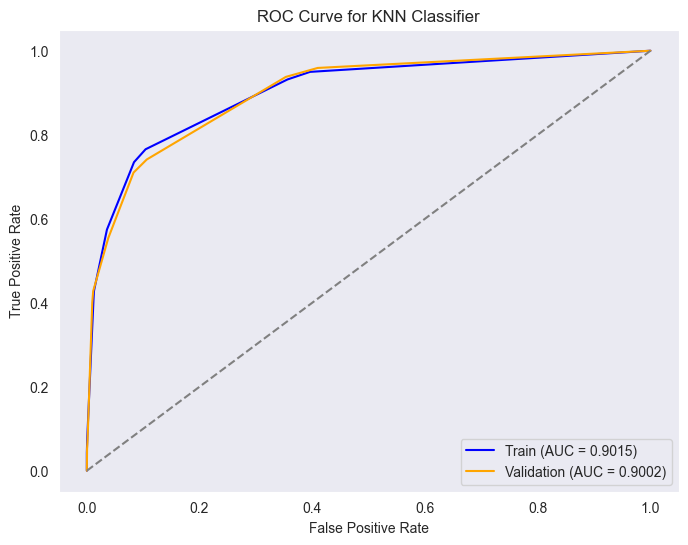

In [49]:
from sklearn.tree import DecisionTreeClassifier
import time

model_tree = DecisionTreeClassifier(random_state=42)
params_decision_tree = {
    'max_leaf_nodes': np.arange(2, 11),
    'max_depth': np.arange(2, 11),
}

start_time = time.time()
trees_gs = GridSearchCV(model_tree, params_decision_tree, n_jobs=-1, cv=3, verbose=1, scoring='roc_auc')
trees_gs.fit(data['X_train'], data['train_targets'])
end_time = time.time()

trees_best = trees_gs.best_estimator_
print(f"Training time: {end_time - start_time:.2f} seconds")
print(trees_gs.best_params_, trees_gs.best_score_)

plot_roc_curve(data, trees_best)

Here I can see that model has almost identical AUC for training and validation sets.
It means, that this model is generalizing better than kNN model.
But this model is still worse than my DecisionTreeModel from previous home assignment.

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Training time: 0.37 seconds


DecisionTreeClassifier(criterion='entropy', max_depth=16, max_leaf_nodes=14,
                       min_samples_leaf=2, min_samples_split=20,
                       random_state=42)

-0.11499999999999999

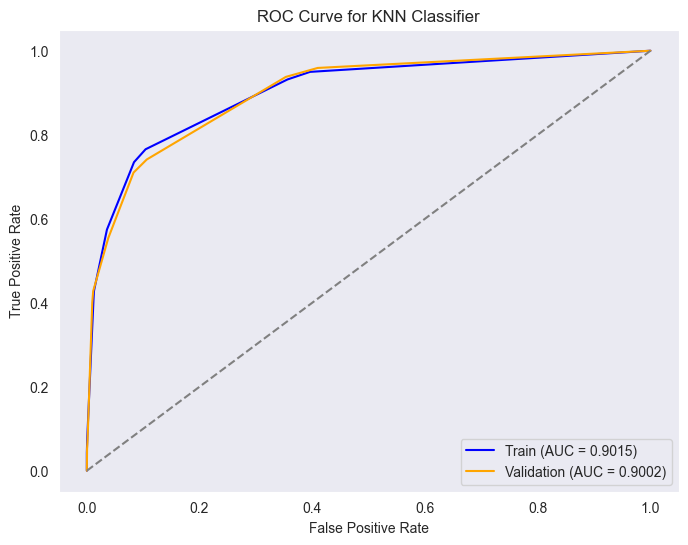

In [50]:
from sklearn.model_selection import RandomizedSearchCV

model_tree = DecisionTreeClassifier(random_state=42)
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

start_time = time.time()
search = RandomizedSearchCV(
    model_tree,
    params_dt,
    n_iter = 40,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=1,
    refit=True,
    random_state=42,
    n_jobs=-1
)

search.fit(data['X_train'], data['train_targets'])
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

display(search.best_estimator_, search.best_score_)

best_model_rand = search.best_estimator_

plot_roc_curve(data, trees_best)

As I can see, the best classifier found with random search is no better than model found with greed search.

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [58]:
from process_bank_churn import process_new_data

clients_df_test = pd.read_csv('csv/test.csv')
new_data = process_new_data(clients_df_test, data['scaler'], data['encoder'])

test_preds_best_model_rand = best_model_rand.predict_proba(new_data)[:,1]

clients_df_test['Exited'] = test_preds_best_model_rand
submission = pd.read_csv('csv/sample_submission.csv')
submission['Exited'] = clients_df_test['Exited']
submission.to_csv('csv/submission_best_model_rand.csv', index=False)

test_trees_best = trees_best.predict_proba(new_data)[:,1]
clients_df_test['Exited'] = test_trees_best
submission = pd.read_csv('csv/sample_submission.csv')
submission['Exited'] = clients_df_test['Exited']
submission.to_csv('csv/submission_test_trees_best.csv', index=False)

test_knn_best = trees_best.predict_proba(new_data)[:,1]
clients_df_test['Exited'] = test_knn_best
submission = pd.read_csv('csv/sample_submission.csv')
submission['Exited'] = clients_df_test['Exited']
submission.to_csv('csv/submission_test_knn_best.csv', index=False)

